### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from itertools import cycle
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

### Machine Learning Libraries

In [2]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Functions

In [3]:
def get_audio_features(df, sp):
    
    # check that it is the right CSV
    if 'uri' not in df.columns or 'track' not in df.columns or 'artist' not in df.columns:
        return
    
    # features to keep
    artist_list = []
    track_list = []
    date_list = []
    rating_list = []
    
    # features to obtain from API
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms = []

    # get features for each URI
    for uri, track, artist in df[['uri', 'track', 'artist']].values:
        if uri != 'NaN':
            try:
                x = sp.audio_features(uri)
                
                if x != None:
                    for audio_features in x:
                        danceability.append(audio_features['danceability'])
                        energy.append(audio_features['energy'])
                        key.append(audio_features['key'])
                        loudness.append(audio_features['loudness'])
                        mode.append(audio_features['mode'])
                        speechiness.append(audio_features['speechiness'])
                        acousticness.append(audio_features['acousticness'])
                        instrumentalness.append(audio_features['instrumentalness'])
                        liveness.append(audio_features['liveness'])
                        valence.append(audio_features['valence'])
                        tempo.append(audio_features['tempo'])
                        duration_ms.append(audio_features['duration_ms'])
                        
                    artist_list.append(artist)
                    track_list.append(track)
                    date_list.append(date)
                    rating_list.append(rating)
                
            except:
                continue
    
    # make dataframe
    spotify_data = pd.DataFrame({'artist':artist_list, 'track':track_list, 'danceability':danceability,
                                 'energy':energy, 'key':key, 'loudness':loudness, 'mode':mode,
                                 'speechiness':speechiness, 'acousticness':acousticness, 
                                 'instrumentalness':instrumentalness, 'liveness':liveness,
                                 'valence':valence, 'tempo':tempo, 'duration_ms':duration_ms})
    
    # save CSV file
    #spotify_data.to_csv(target_filename)

    return spotify_data

In [4]:
def get_spotify_uris(df, sp):
    
    # CSV should contain columns:
    # - track
    # - artist
    # - date
    # - rating
    
    # read CSV
    #df = pd.read_csv(csv_file)
    
    # check that it is the right CSV
    if 'track' not in df.columns or 'artist' not in df.columns:
        return
    
    # clean dataframe rows
    #df = df.drop_duplicates()
    #df['track'] = [str(track)[2:-1].split('/')[0].split('(')[0].replace('"','').strip() for track in df['track']]
    #df['artist'] = [str(artist)[2:-1] for artist in df['artist']]
    
    # get URI list
    saved_uris = []
    for artist, track in df[['artist', 'track']].values:
        q = f'artist:{artist} track:{track}'
        results = sp.search(q=q, limit=1, type='track')
        if results['tracks']['total'] != 0:
            uri = results['tracks']['items'][0]['uri']
        else:
            uri = "NaN"
        saved_uris.append(uri)
    
    #print(f'Got {df.shape[0]} URIs.')
    
    # save dataframe
    df['uri'] = saved_uris
    
    # return dataframe
    return df

In [5]:
def authenticate_spotify():
    client_id = '7f6130cdb9904b398f0c0f94b880412f'
    client_secret = '88f25b600aea4def8d7b8f1394c79df8'
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [7]:
def predict_rating():
    artist = []
    track = []
    artist.append(input("Enter artist name: "))
    track.append(input("Enter track name: "))
    music_df = pd.DataFrame({'artist': artist, 'track': track})
    sp = authenticate_spotify()
    uris_df = get_spotify_uris(music_df, sp)
    if uris_df['uri'][0] != "NaN":
        spotify_data = get_audio_features(uris_df,sp)
        predict = rf.predict(spotify_data.drop(columns = ['artist','track']))
        print("Rating prediction: " + str(predict))
    else:
        print("\nFeatures not found on spotify API")

### Dataset

In [ ]:
'''
duration_ms: The duration of the track in milliseconds.

key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.
E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.
Major is represented by 1 and minor is 0.

time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to
specify how many beats are in each bar (or measure).

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the
track is acoustic.

danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements
including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most
danceable.

energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude
scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness,
timbre, onset rate, and general entropy.

instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this
context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater
likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but
confidence is higher as the value approaches 1.0.

liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability
that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are
useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological
correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the
recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks
that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both
music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent
music and other non-speech-like tracks.

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence
sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative
(e.g. sad, depressed, angry).

tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed
or pace of a given piece and derives directly from the average beat duration.'''

In [8]:
df = pd.read_csv('RYM_Spotify_data.csv')

In [9]:
df.head(1)

,artist,track,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
0,The Beach Boys,Wouldn’t It Be Nice,0.522,0.352,193400,0.597,0.000005,9,0.142,-6.603,0,0.0361,125.014,0.316,4.45


In [10]:
df.isna().sum()

artist              0
track               0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
rating              0
dtype: int64

In [11]:
df.dtypes

artist               object
track                object
acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
valence             float64
rating              float64
dtype: object

### Features

In [12]:
df['rating'] = [round(rating) for rating in df['rating']]

In [13]:
df.shape

(19651, 15)

In [14]:
df.columns

Index(['artist', 'track', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'rating'],
      dtype='object')

### EDA

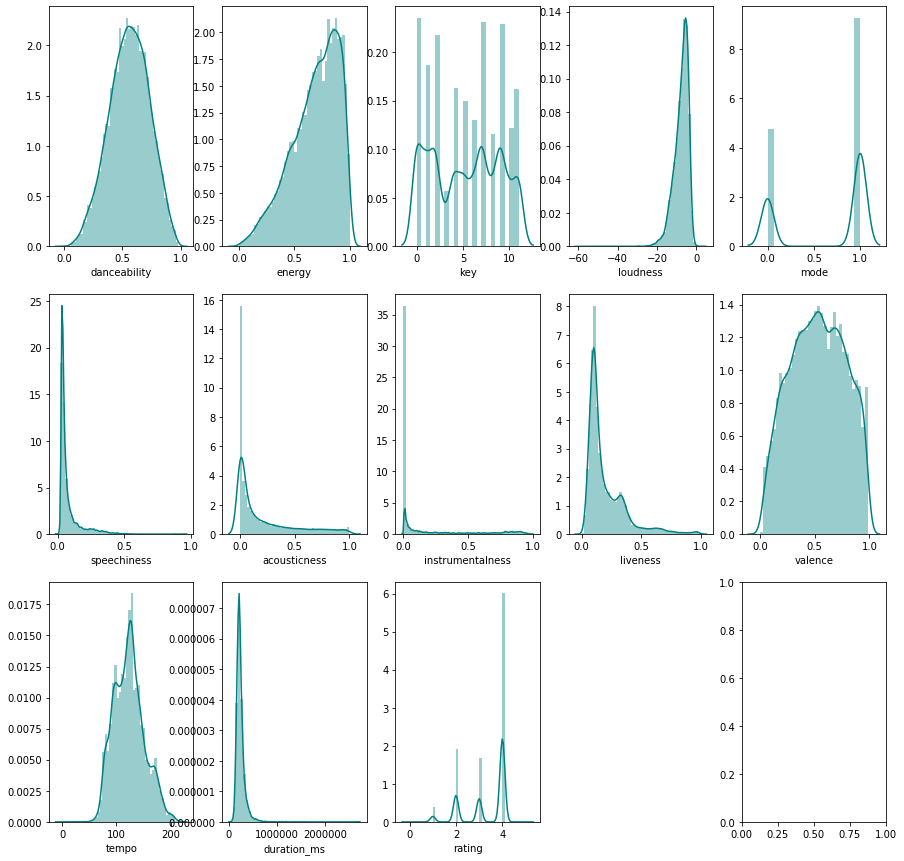

In [15]:
f, axes = plt.subplots(3, 5, figsize=(15, 15))
sns.distplot(df["danceability"] , color="teal", ax=axes[0, 0])
sns.distplot(df["energy"] , color="teal", ax=axes[0, 1])
sns.distplot(df["key"] , color="teal", ax=axes[0, 2])
sns.distplot(df["loudness"] , color="teal", ax=axes[0, 3])
sns.distplot(df["mode"] , color="teal", ax=axes[0, 4])
sns.distplot(df["speechiness"] , color="teal", ax=axes[1, 0])
sns.distplot(df["acousticness"] , color="teal", ax=axes[1, 1])
sns.distplot(df["instrumentalness"] , color="teal", ax=axes[1, 2])
sns.distplot(df["liveness"] , color="teal", ax=axes[1, 3])
sns.distplot(df["valence"] , color="teal", ax=axes[1, 4])
sns.distplot(df["tempo"] , color="teal", ax=axes[2, 0])
sns.distplot(df["duration_ms"] , color="teal", ax=axes[2, 1])
sns.distplot(df["rating"] , color="teal", ax=axes[2, 2])
f.delaxes(axes[2][3])

plt.show()

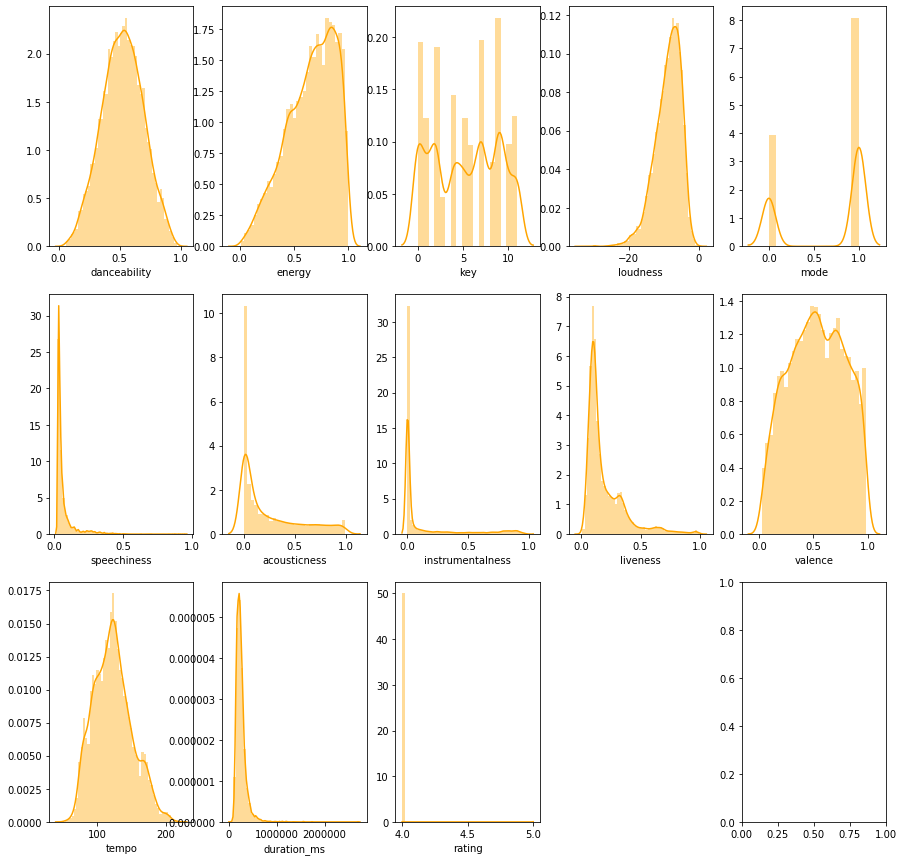

In [16]:
df_top_rating = df.loc[df['rating'] > 3]
f, axes = plt.subplots(3, 5, figsize=(15, 15))
sns.distplot(df_top_rating["danceability"] , color="orange", ax=axes[0, 0])
sns.distplot(df_top_rating["energy"] , color="orange", ax=axes[0, 1])
sns.distplot(df_top_rating["key"] , color="orange", ax=axes[0, 2])
sns.distplot(df_top_rating["loudness"] , color="orange", ax=axes[0, 3])
sns.distplot(df_top_rating["mode"] , color="orange", ax=axes[0, 4])
sns.distplot(df_top_rating["speechiness"] , color="orange", ax=axes[1, 0])
sns.distplot(df_top_rating["acousticness"] , color="orange", ax=axes[1, 1])
sns.distplot(df_top_rating["instrumentalness"] , color="orange", ax=axes[1, 2])
sns.distplot(df_top_rating["liveness"] , color="orange", ax=axes[1, 3])
sns.distplot(df_top_rating["valence"] , color="orange", ax=axes[1, 4])
sns.distplot(df_top_rating["tempo"] , color="orange", ax=axes[2, 0])
sns.distplot(df_top_rating["duration_ms"] , color="orange", ax=axes[2, 1])
sns.distplot(df_top_rating["rating"] , color="orange", ax=axes[2, 2])
f.delaxes(axes[2][3])

plt.show()

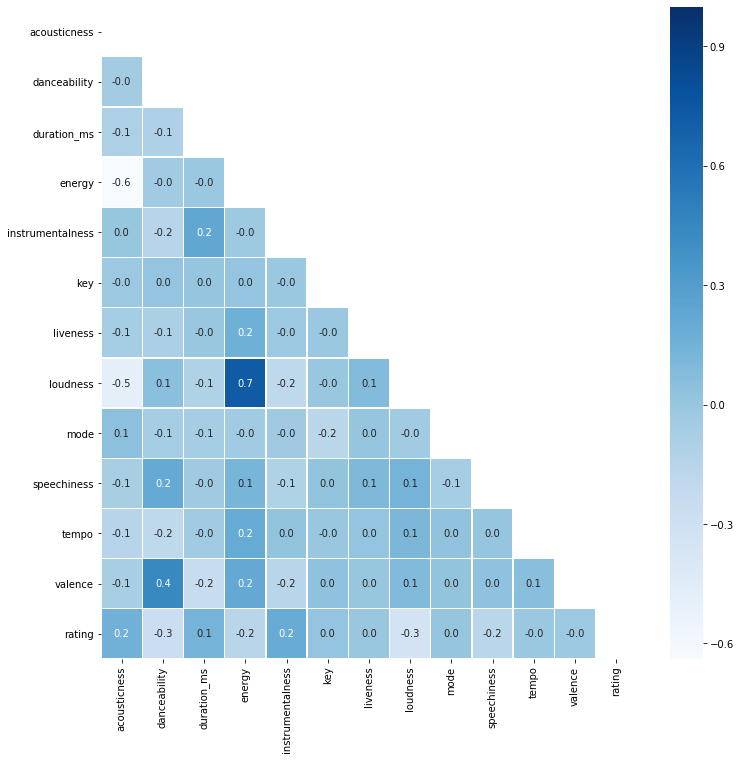

In [17]:
f,ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show() 

### Features

In [18]:
for column in df.columns:
    print(column + " has " + str(len(df[column].value_counts())) + " unique values.")

artist has 5813 unique values.
track has 15113 unique values.
acousticness has 4019 unique values.
danceability has 977 unique values.
duration_ms has 11432 unique values.
energy has 1073 unique values.
instrumentalness has 4424 unique values.
key has 12 unique values.
liveness has 1602 unique values.
loudness has 9267 unique values.
mode has 2 unique values.
speechiness has 1254 unique values.
tempo has 14068 unique values.
valence has 1326 unique values.
rating has 6 unique values.


### Logistic Regression

In [19]:
df.columns

Index(['artist', 'track', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'rating'],
      dtype='object')

In [20]:
y = df['rating']
X = df.drop(columns = ['artist','track','rating'])

In [21]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size = 0.8, test_size = 0.2)

In [22]:
lr_model = LogisticRegression()

In [23]:
lr_model.fit(X_train, y_train)
y_predict = lr_model.predict(X_test)

C:\Users\Filipe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Filipe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
logistic_score = accuracy_score(y_test,y_predict)*100

In [25]:
logistic_score

60.64614601882473

### K-Nearest Neighbors

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

In [27]:
k_near_model = KNeighborsClassifier(n_neighbors = 3)
k_near_model.fit(X_train, y_train)
y_predict = k_near_model.predict(X_test)

In [28]:
knn_score = accuracy_score(y_test, y_predict)*100

In [29]:
knn_score

53.06330144514553

### SVM

In [30]:
from sklearn.svm import SVC
svm= SVC(random_state=2)
svm.fit(X_train,y_train)
svm_score = svm.score(X_test,y_test)

C:\Users\Filipe\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
svm_score = svm.score(X_test,y_test)*100

In [32]:
svm_score

63.76959088133523

### Naive Bayes

In [33]:
nb= GaussianNB()
nb.fit(X_train,y_train)
nb_score = nb.score(X_test,y_test)*100

In [34]:
nb_score

62.772236922450645

### Decision Tree Classifier

In [35]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
dt= DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
DecisionTree_score=dt.score(X_test,y_test)
dt_score = dt.score(X_test,y_test)*100

In [36]:
dt_score

63.93242418074496

### Random Forest Classifier

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

rf=RandomForestClassifier(random_state = 42)
rf.fit(X_train,y_train)
rfc_score = rf.score(X_test,y_test)*100
y_pred=rf.predict(X_test)
t_true=y_test

C:\Users\Filipe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
rfc_score

68.69529818847954

In [43]:
predict_rating()

Enter artist name: Britney Spears
Enter track name: Toxic
Rating prediction: [1]


### Cool map

In [39]:
feature_list = X.columns

In [ ]:
'''# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')'''

### Random Hyperaramter Grid

In [40]:
forestVC = RandomForestClassifier(random_state = 1,
                                  n_estimators = 750,
                                  max_depth = 15, 
                                  min_samples_split = 5,  min_samples_leaf = 1) 
modelVC = forestVC.fit(X_train, y_train) 
y_predVC = modelVC.predict(X_test)

In [55]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

#hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)

#gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
#bestF = gridF.fit(X_train, y_train)

In [ ]:
#bestF.best_params_

In [ ]:
# Best Parameters:

'''{'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}'''

### New model with hyperparameter

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 29)

rf_improved=RandomForestClassifier(max_depth = 25, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 1200)

rf_improved.fit(X_train,y_train)
rfc_score_improved = rf_improved.score(X_test,y_test)*100
y_pred=rf.predict(X_test)
t_true=y_test
rfc_score_improved

71.38204762874008

### Model Comparison

In [48]:
model_performances=pd.DataFrame({'Model':['RandomForestClassifierImproved','RandomForestClassifier','SVM','DesicionTreeClassifier','K-NearestNeighbors','LogisticRegession','NaiveBayes'],
                                 'Accuracy':[rfc_score_improved,rfc_score,svm_score,dt_score,knn_score,logistic_score,nb_score]})
model_performances.sort_values(by = "Accuracy",ascending=False)

,Model,Accuracy
0,RandomForestClassifierImproved,71.382048
1,RandomForestClassifier,68.695298
3,DesicionTreeClassifier,63.932424
2,SVM,63.769591
6,NaiveBayes,62.772237
5,LogisticRegession,60.646146
4,K-NearestNeighbors,53.063301


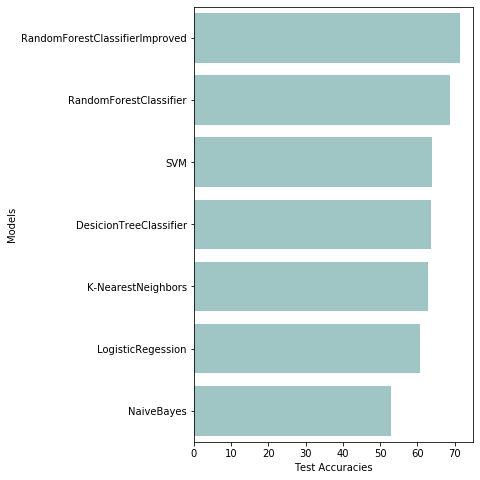

In [60]:
model_list= list(model_performances['Model'].unique())
accuracy_list= list(model_performances['Accuracy'].sort_values(ascending=False))
f,ax = plt.subplots(figsize = (5,8))
sns.barplot(x=accuracy_list,y=model_list,color='teal',alpha = 0.4)
ax.set(xlabel='Test Accuracies', ylabel='Models')
plt.show()

In [69]:
predict_rating()

Enter artist name: David Bowie
Enter track name: Life on Mars
Rating prediction: [4]


In [70]:
predict_rating()

Enter artist name: Britney Spears
Enter track name: Toxic
Rating prediction: [1]
